In [1]:
!pip install -Uqq fastai fastcore
!pip install corner

Installing required libraries for fastai.

In [2]:
import fastai
fastai.__version__

'2.2.7'

Importing necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import fastai

from scipy import stats
import seaborn as sns

from fastai import learner
from fastai.tabular.all import *
from fastai.data import core

from fastai.metrics import mse

import matplotlib as mpl
import corner.corner as corner

Mounting google drive for loading necessary pickle files

In [4]:
import os 
dir_path = os.getcwd()

dataset = pd.read_pickle(dir_path+'/processed_datalabel.pkl')

Converting object entries to float64

In [5]:
if 'proc_id' in dataset:
  dataset = dataset.drop(columns=['proc_id'])

dataset = dataset.astype('float64')

Splitting dataset into two parts:

1. `train` set containing of 70% of dataset.

2. `test` set containing of 30% of dataset.

In [6]:
from sklearn.utils import shuffle

#Using only necessary dataset entries
dataset = dataset[['e','pt','eta','phi']]

#Shuffling dataset rows to select random entries
dataset = shuffle(dataset)

ln = len(dataset)

#Point to divide the data
pvt = int(ln*(7/10))

train = dataset[:pvt]
test = dataset[pvt+1:]

Dataset has a wide range of `e` and `pt` values which can affect performance of the autoencoder.

To overcome this, normalise the entries by converting it into a suitable range.

1. `e` and `pt` values are normalised using log scale.

2. `eta` and `phi` values are divided by `5` and `3` respectively.

The normalisation factors and process is cited from masters thesis of Eric Wulff [link](https://lup.lub.lu.se/student-papers/search/publication/9004751).

In [7]:
import copy

#Function to Normalise data
def normalise(data):
  df2 = data.copy()
  #Converting to GeV
  df2['e'] = (data['e'] / 1000)
  df2['pt'] = data['pt'] / 1000
  
  #Normalising data to reduce range of distribution of jet values 
  df2['e'] = np.log10(data['e'])
  df2['pt'] = np.log10(data['pt'])  
  df2['eta'] = data['eta'] / 5
  df2['phi'] = data['phi'] / 3
  return df2

Normalising values.

In [8]:
#Normalise input values
train_normal_x = normalise(train)
test_normal_x = normalise(test)


#In an Autoencoder input value(x) = output value(y)
train_normal_y = train_normal_x 
test_normal_y = test_normal_x

Function to plot histograms of the normalised data.

In [9]:

#Units for plots
unit_list =  ['[log(GeV)]','[log(GeV)]', '[rad/5]', '[rad/3]']

#Variable representation
variable_list = [r'$e$', r'$p_T$', r'$\eta$', r'$\phi$']

#Visual parameters for the plot
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

n_bins = 100

#Function to plot histograms of all jet values.
def histogram(data):
    plt.close('all')

    # Histograms
    idxs = (0, ln)  
    data = data[idxs[0]:idxs[1]].values

    alph = 0.8
    n_bins = 50
    for kk in np.arange(4):
        plt.figure(kk + 4)
        n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
        plt.suptitle(test.columns[kk])
        plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
        plt.ylabel('Number of events')
        plt.legend()

Plotting histograms for normalised data.

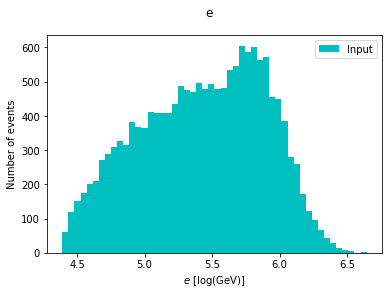

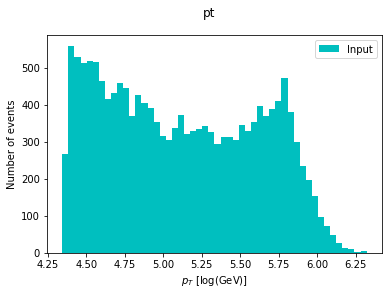

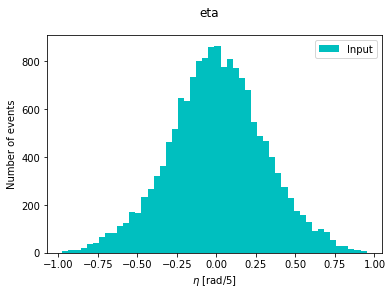

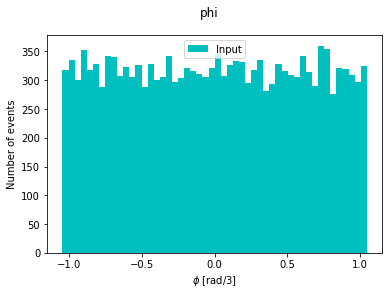

In [10]:
histogram(train_normal_x)

`Autoencoders`

`Autoencoders` are a class of neural networks that are used to reduce dimensionality thus working as data compressors. 

Architecture:




`En1`: The input layer takes 4 jet features as input and produces linear transformed 200 features.

`En2`: The input layer takes 200 features and scales down to 100 features.

`En3`: The input layer takes 100 features and scales down to 50 features.

`En4`: The input layer takes 50 features and scales down to 3 features.

The resulting output from En4 is the `compressed data` in 3 variable form. This can be stored in pickled format for later use.

The compressed data can be recovered by passing it through the decoder part of the autoencoder.

`Dec1`: The input layer takes 3 features and scales up to 50 features.

`Dec2`: The input layer takes 50 features and scales up to 100 features.

`Dec3`: The input layer takes 100 features and scales up to 200 features.

`Dec4`: The input layer takes 200 features and scales up to 4 features.


Dataflow:

1. Encoder

    Input -> En1 -> En2 -> En3 -> En4 --> compressed code/data
                                                           
2. Decoder

    compressed data --> Dec1 -> Dec2 -> Dec3 -> Dec4 -> Input


For illustration:

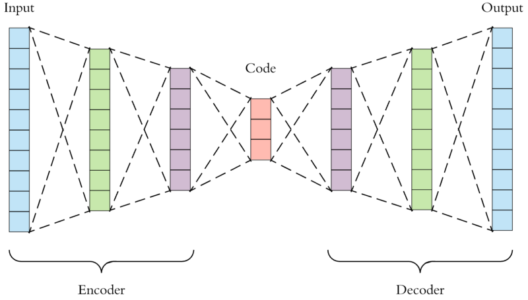



In [11]:

class AE_3D_200(nn.Module):

    #Initialise the components
    def __init__(self, n_features=4):
        super(AE_3D_200, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    #Encoder part
    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    #Decoder part
    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    #An autoencoding cycle
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

model = AE_3D_200()

Making data ready for feeding to model

In [12]:
#Batch size
bs = 256

#Converting dataset from Dataframe to tensordataset
train_ds = TensorDataset(torch.tensor(train_normal_x.values, dtype=torch.float), torch.tensor(train_normal_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_normal_y.values, dtype=torch.float), torch.tensor(test_normal_y.values, dtype=torch.float))

#Dataloaders to ease the process of feeding data to the model
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

dls = DataLoaders(train_dl, valid_dl)

Print model inner layers

In [13]:
model.to('cpu')

AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

Using MSE as loss functions.

Referred from Eric Wulfer's thesis.

In [14]:
loss_func = nn.MSELoss()

recorder = learner.Recorder()

learn = learner.Learner(dls, model=model, loss_func=loss_func, lr=0.001, cbs=recorder)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.002511886414140463)

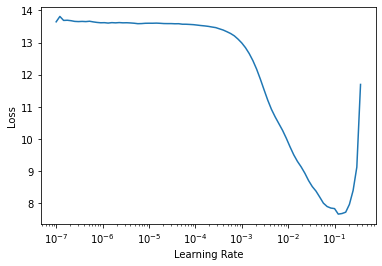

In [15]:
learn.lr_find()

Training model.

In [16]:
learn.fit(n_epoch=100)

epoch,train_loss,valid_loss,time
0,1.418337,0.228622,00:00
0,1.418337,0.228622,00:00
1,0.494611,0.225322,00:00
1,0.494611,0.225322,00:00
2,0.300248,0.226473,00:00
2,0.300248,0.226473,00:00
3,0.249252,0.226026,00:00
3,0.249252,0.226026,00:00
4,0.234787,0.224466,00:00
4,0.234787,0.224466,00:00


Plotting loss curves for train dataset.

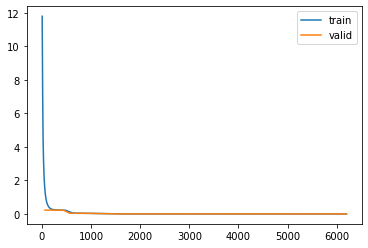

In [17]:
learn.recorder.plot_loss()

Learning rate with the minimum loss: 4.786300996784121e-05
Learning rate with the steepest gradient: 4.786300905834651e-06


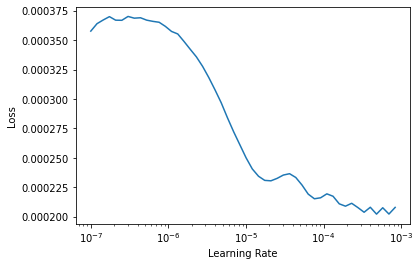

In [18]:
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [19]:
learn.validate()

(#1) [0.0003766538284253329]

Plotting the predicted and input data as a histogram displays performance of the compressor.

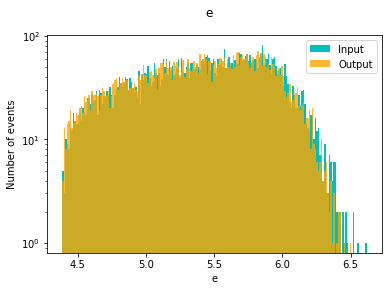

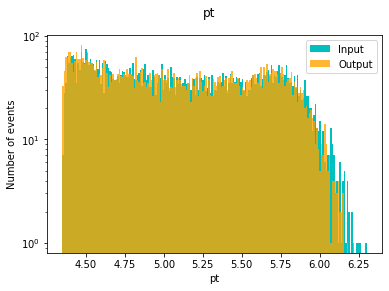

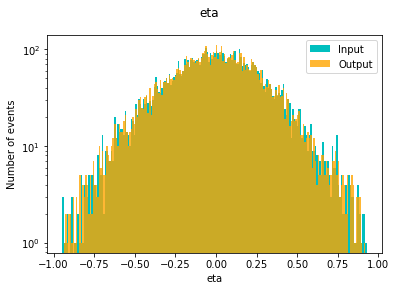

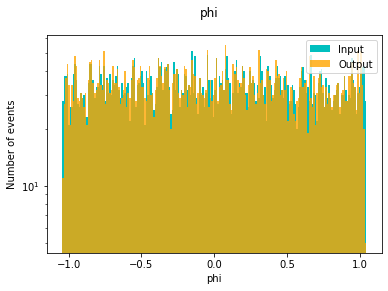

In [20]:
plt.close('all')

#Function to define graph visualisation
def sciy():
    plt.gca().ticklabel_format(style='sci', scilimits=(0, 0), axis='y')

#Function to plot input vs output histogram
def plot_hst(test):

  #Events range to compare 
  idxs = (0, ln)
  data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)

  pred = model(data)
  pred = pred.detach().numpy()
  data = data.detach().numpy()

  data_df = pd.DataFrame(data, columns=test.columns)
  pred_df = pd.DataFrame(pred, columns=test.columns)

  alph = 0.8
  n_bins = 200
  for kk in np.arange(4):
      plt.figure()
      n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
      n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
      plt.suptitle(test.columns[kk])
      plt.xlabel(test.columns[kk])
      plt.ylabel('Number of events')
      sciy()

      plt.yscale('log')
      plt.legend()

plot_hst(test_normal_x)

Plotting input vs output graph and plot of ratio of the input to output relation for each jet event.

<Figure size 432x288 with 0 Axes>

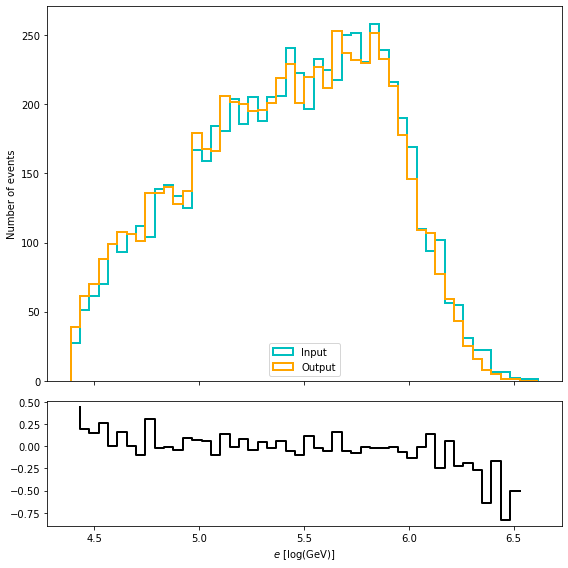

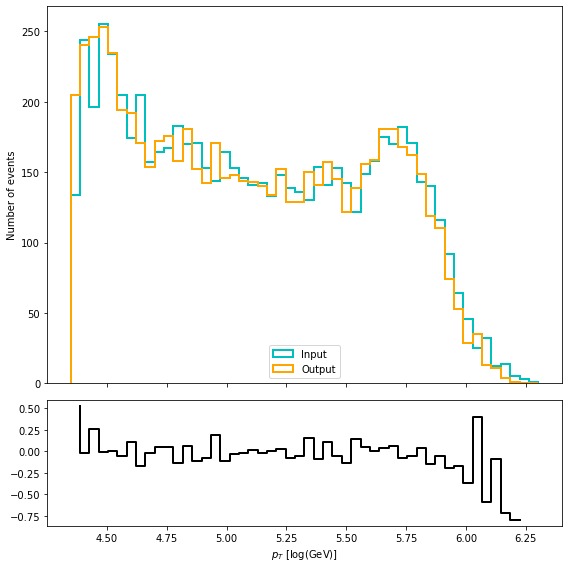

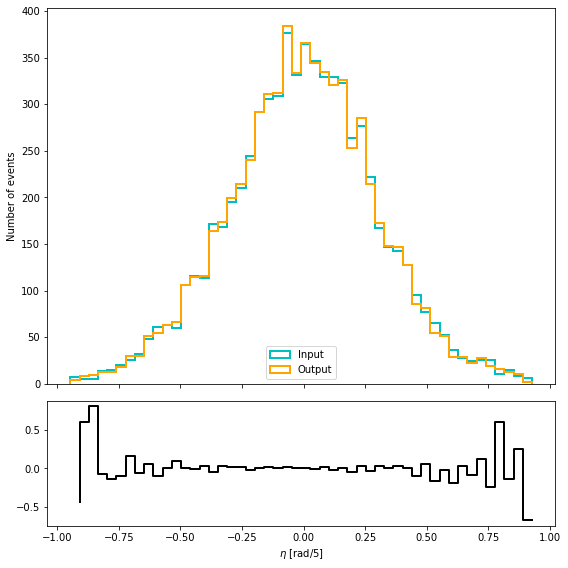

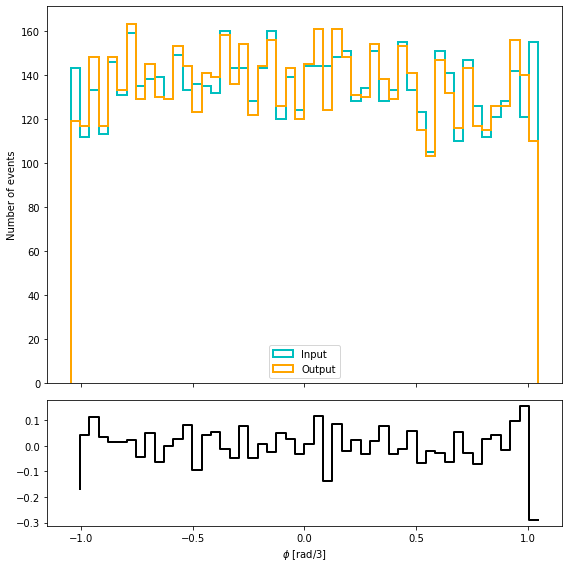

In [21]:
#Function to return ratio of input and output
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins

idxs = (0,ln)
data = torch.tensor(test_normal_x[idxs[0]:idxs[1]].values, dtype=torch.float)

#Prediction of test sample
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

#Plotting histogram and ratio plots
alph = 0.8
n_bins = 50
for kk in [0,1,2,3]:
    plt.figure(kk + 4)
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8),gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    n_hist_data, bin_edges, _ = ax1.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins, histtype="step",linewidth=2)
    n_hist_pred, _, _ = ax1.hist(pred[:, kk], color=colors[0], label='Output', alpha=1, bins=bin_edges, histtype='step',linewidth=2)
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    ax1.set(ylabel='Number of events')
    ax1.legend(loc=8)
    
    #Plotting ratio plots
    rat = getRatio(n_hist_data,n_hist_pred)
    ax2.step(bin_edges[1:],rat, color='black',linewidth=2)
    plt.tight_layout()

Plotting residuals for each jet entries 

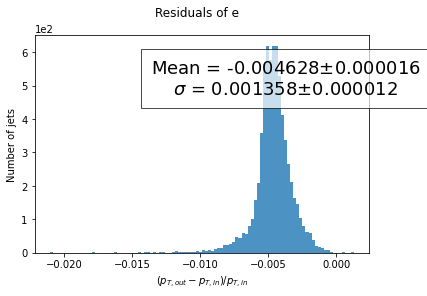

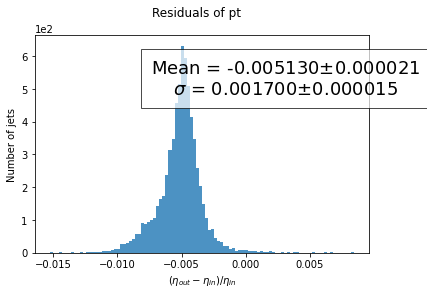

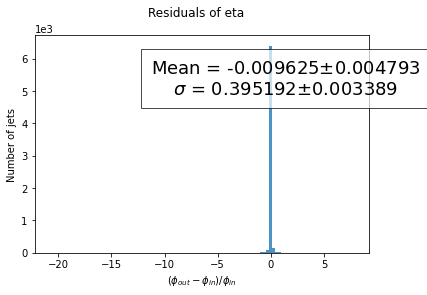

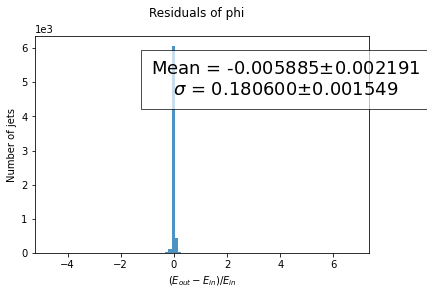

In [22]:

#Function to calculate std error of the data
def std_error(x, axis=None, ddof=0):
    return np.nanstd(x, axis=axis, ddof=ddof) / np.sqrt(2 * len(x))

#Function to plot the reconstruction loss
def resid(data,pred): 
  residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                            r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                            r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                            r'$(E_{out} - E_{in}) / E_{in}$']
  residuals = (pred - data)/data
  aplh=0.8

  lst = ['e', 'pt', 'eta', 'phi']

  for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
            residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=0.8, bins=100)
    plt.suptitle('Residuals of %s' % lst[kk])
    plt.xlabel(residual_strings[kk])
    plt.ylabel('Number of jets')
    sciy()

    std = np.std(residuals[:, kk])
    std_err = std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
                 horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
  return residuals

residual_vars = resid(data,pred)

Plotting correlation of residuals of each jet entries

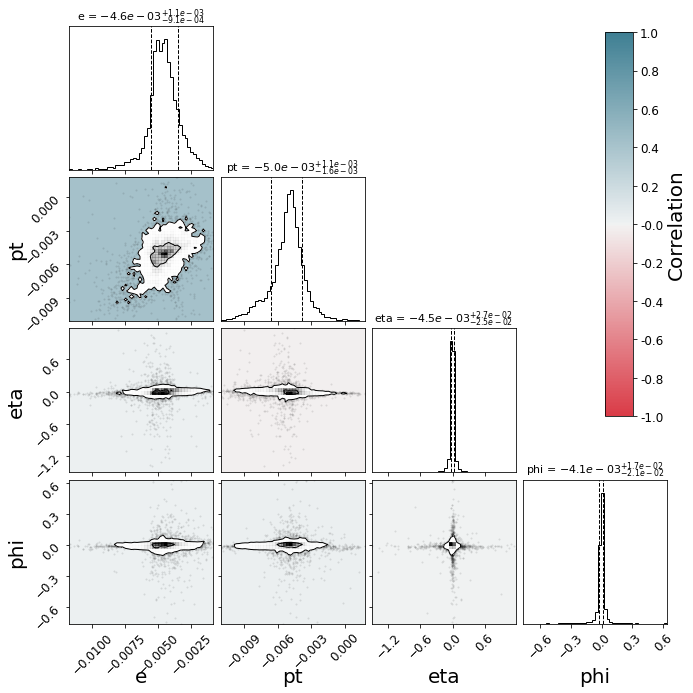

In [23]:

#Function to plot correlation between the different variable residuals
def correlations(residuals):
    res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'e': residuals[:, 3]})

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)

    norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    group = ['e','pt','eta','phi']

    label_kwargs = {'fontsize': 20}
    title_kwargs = {"fontsize": 11}
    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    group_arr = res_df.values
    corr = res_df.corr()
    qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
    ndim = qs.shape[1]
    ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
    figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False,
                    bins=50, labels=group, label_kwargs=label_kwargs,
                    show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                    levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    # Loop over the diagonal
    linecol = 'r'
    linstyl = 'dashed'
    # Loop over the histograms
    for yi in np.arange(ndim):
        for xi in np.arange(yi):
            ax = axes[yi, xi]
            # Set face color according to correlation
            ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
    cax = figure.add_axes([.87, .4, .04, 0.55])
    cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
    cbar.ax.set_ylabel('Correlation', fontsize=20)

correlations(residual_vars)